# Advance lane finding
In the last two notebooks (4 & 5) we have looked at

* camera calibration and correcting distortion
* perspective transform
* gradient threshold
* color threshold

In this notebook, we go through a pipeline using above technique to detect lane line. The pipeline has following steps

1. camera calibration
2. distortion correction
3. color & gradient threshold: filter useful information
4. perspective transform: view image in a bird's eye view perspective
5. find the lines using **sliding-window-search**
6. measure curvature and car position

First, let's import some modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

## Camera calibration & distortion correction
Let's start with camera calibration 

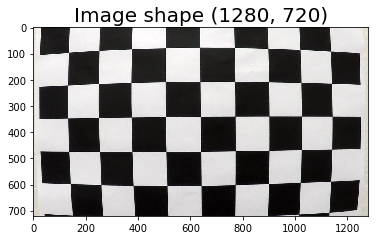

In [72]:
calib_imgs = glob.glob('CarND-P4-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
calib_imgs = np.sort(calib_imgs)
img0 = mpimg.imread(calib_imgs[0])

# get image shape
H, W, C = img0.shape
IMG_CV_SHAPE = (W, H)

_ = plt.imshow(img0)
_ = plt.title('Image shape {}'.format(IMG_CV_SHAPE), fontsize=20)

In [3]:
# find conners and draw conners on the image
def find_corners(bgr, nx, ny):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    #print (gray.shape, gray.shape[::-1])
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # cv2.drawChessboardCorners(rgb, (nx, ny), corners, ret)
    return ret, corners

def get_img_obj_points(imgs, nx, ny):
    imgs_points = []
    obj_points = []
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for img in imgs:
        bgr = cv2.imread(img)
        ret, conners = find_corners(bgr, nx, ny)
        if (ret):
            imgs_points.append(conners)
            obj_points.append(objp)
           
    return imgs_points, obj_points

Nx = 9
Ny = 5
# get imgs points, object points then calibrate
imgs_points, obj_points = get_img_obj_points(calib_imgs, Nx, Ny)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, imgs_points, IMG_CV_SHAPE, None, None)

In [4]:
def show_img(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img)
    ax.axis('off')

def view_imgs(imgs, labels, figsize, multi_col = True, sharex = True, sharey = True):
    nrows = 1 if multi_col else len(labels)
    ncols = len(labels) if multi_col else 1
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)

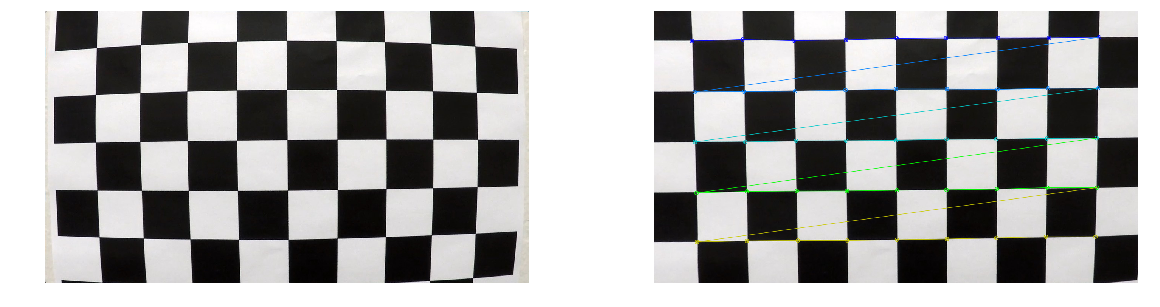

In [5]:
undist_img = cv2.undistort(img0, mtx, dist, None, mtx)
ret, corners = find_corners(undist_img, Nx, Ny)
cv2.drawChessboardCorners(undist_img, (Nx, Ny), corners, ret)
view_imgs([img0, undist_img], [None, None], (20,5))

## Gradient and color threshold
Next we will use gradient/color threshold to create binary image.

['./CarND-P4-Advanced-Lane-Lines/test_images/straight_lines1.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/straight_lines2.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/test1.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/test2.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/test3.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/test4.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/test5.jpg'
 './CarND-P4-Advanced-Lane-Lines/test_images/test6.jpg']


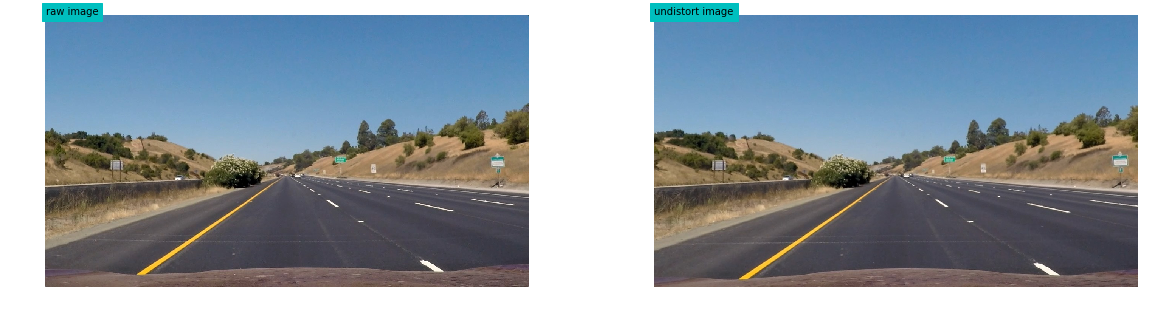

In [114]:
# Get road files
road_files = glob.glob('./CarND-P4-Advanced-Lane-Lines/test_images/*.jpg')
road_files = np.sort(road_files)
print(road_files)

# Load and correct it
road0 = mpimg.imread(road_files[0])
undist_road0 = cv2.undistort(road0, mtx, dist, None, mtx)

# Visualize it
view_imgs([road0, undist_road0], ['raw image', 'undistort image'], (20,5))

We implement the following threshold functions
* absolute Sobel threshold in x/y
* magniture Sobel threshold
* direction threshold
* color threshold using S-channel

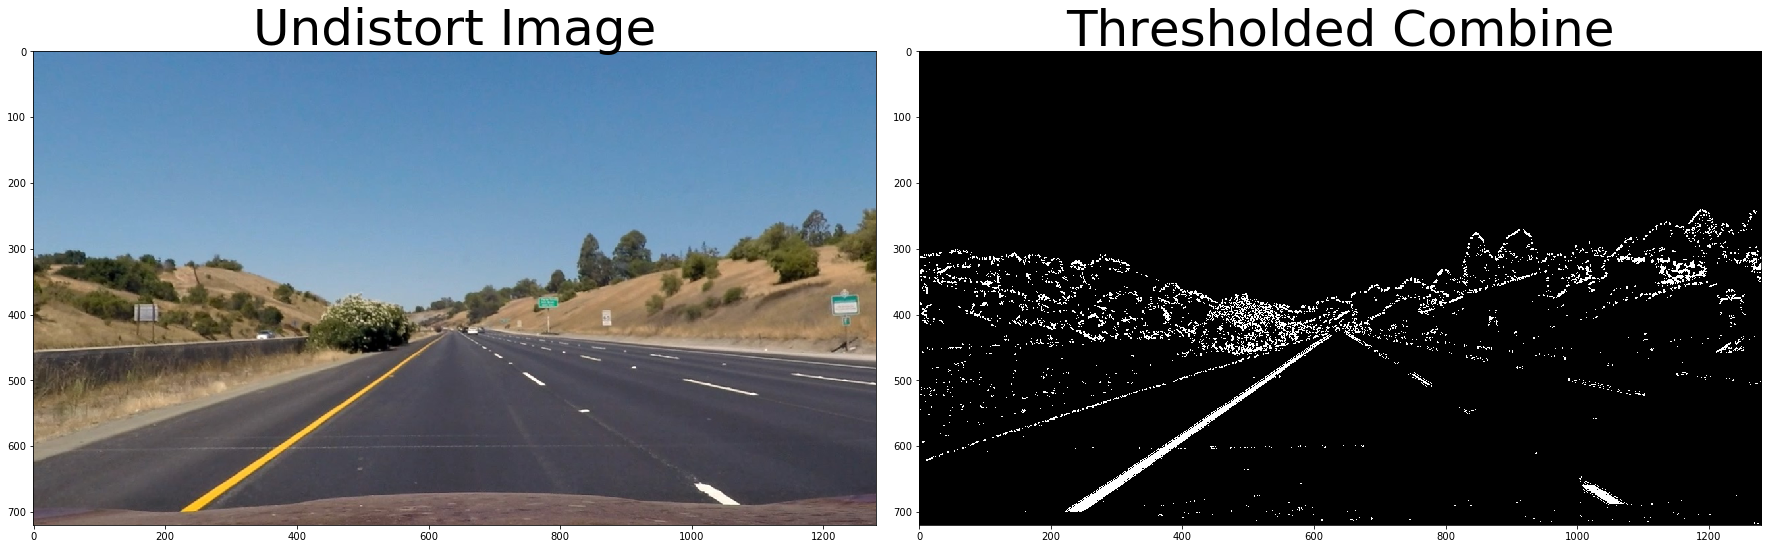

In [115]:
def abs_sobel_thresh(img_channel, sobel_kernel=3, orient='x', thresh = (0,255)):
    '''
    absolute Sobel threshold in a specific direction
    args: 
        img_channel: is a channel of the image (e.g grayscale channel or S channel e.t.c)
    '''
    if orient == 'x':
        sobel = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255. * sobel / np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_thresh(img_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    '''
    magniture threshold sqrt(sobolx^2 + soboly^2)
    args:
        img_channel: is a channel of the image
    '''
    sobelx = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    magn = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_magn = np.uint8(255*magn/np.max(magn))
    
    binary_output = np.zeros_like(magn)
    binary_output[(scaled_magn >= mag_thresh[0]) & (scaled_magn <= mag_thresh[1])] = 1
    
    return binary_output

def dir_thresh(img_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    apply direction threshold
    '''
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    binary_output = np.zeros_like(absgraddir)
    
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

def color_thresh(img_channel, thresh = (0,255)):
    '''
    apply color threshold
    '''
    binary_output = np.zeros_like(img_channel)
    binary_output[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary_output

def combined_threshold(img_rgb, ksize=3):
    
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_thresh(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    color_bin = color_thresh(hls[:,:,2], thresh=(150, 255))

    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_bin==1)] = 1
    return combined

undist_road0_bin = combined_threshold(undist_road0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_road0)
ax1.set_title('Undistort Image', fontsize=50)
ax2.imshow(undist_road0_bin, cmap='gray')
ax2.set_title('Thresholded Combine', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform
The next step is to define four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective

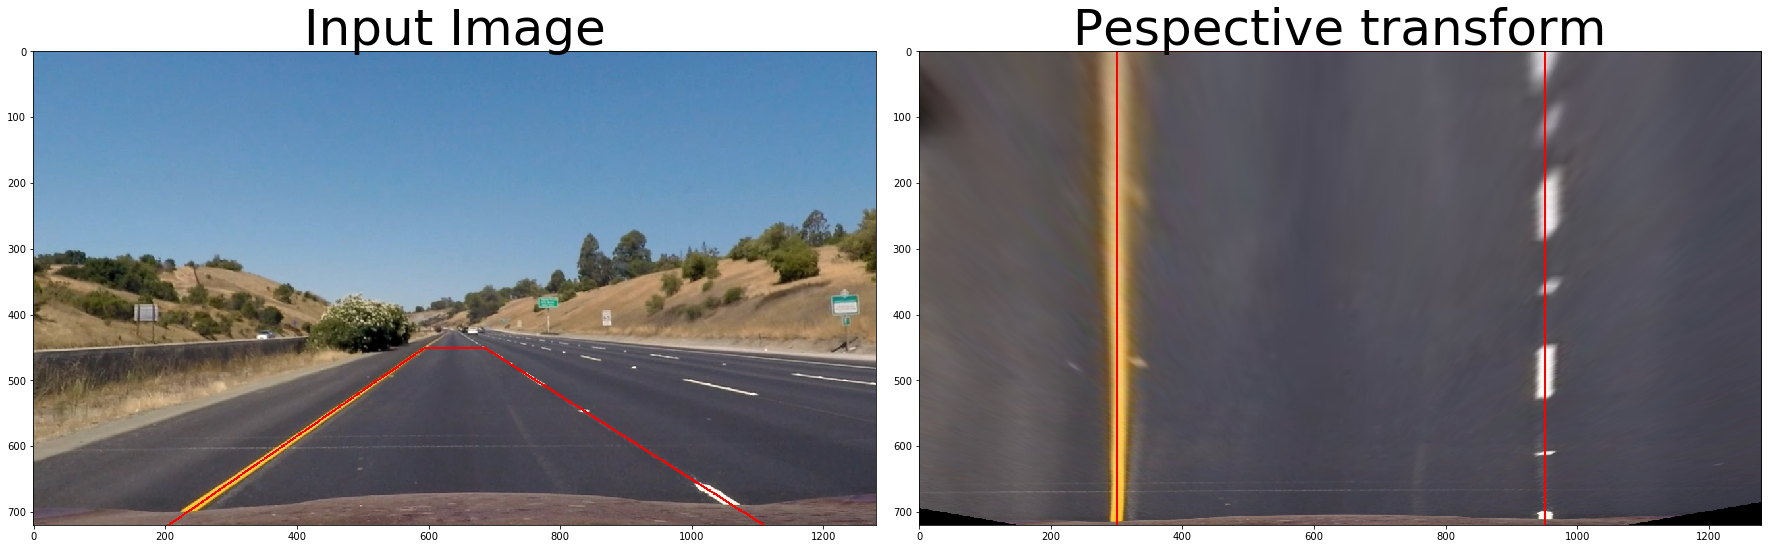

In [116]:
src_points = np.float32([(205, 720), (595,450), (685,450), (1110,720)])
dst_points = np.float32([(300, 720), (300, 0),  (950, 0),  (950, 720)])

def view_presp_trans(in_img, src_points, dst_points, cmap=None):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    img = np.copy(in_img)
    warped = cv2.warpPerspective(img, M, IMG_CV_SHAPE, flags=cv2.INTER_LINEAR) 
    
    if (cmap==None):
        for i in range(3):
            cv2.line(img,    tuple(src_points[i]), tuple(src_points[i+1]), color=[255, 0, 0], thickness=2)
            cv2.line(warped, tuple(dst_points[i]), tuple(dst_points[i+1]), color=[255, 0, 0], thickness=2)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img, cmap=cmap)
    ax1.set_title('Input Image', fontsize=50)
    ax2.imshow(warped, cmap=cmap)
    ax2.set_title('Pespective transform', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
view_presp_trans(undist_road0, src_points, dst_points)

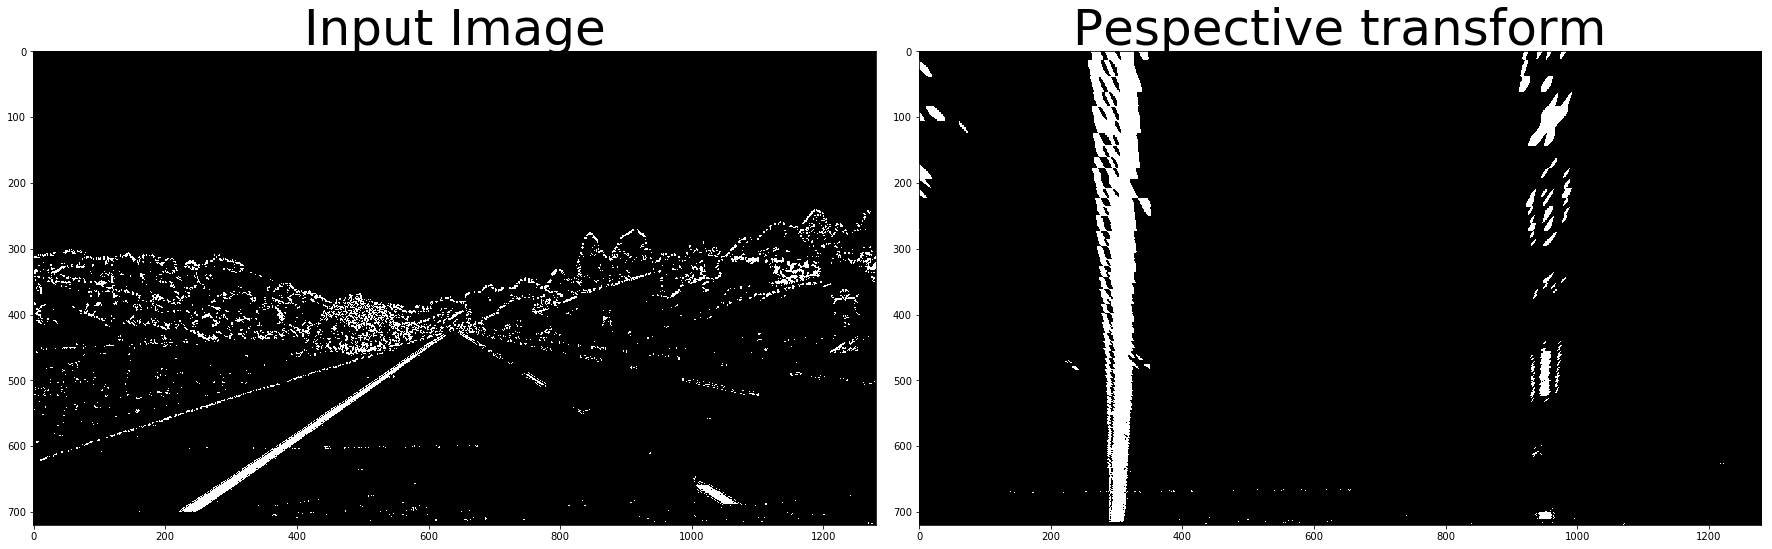

In [117]:
view_presp_trans(undist_road0_bin, src_points, dst_points, cmap='gray')
#plt.imshow(undist_road0_bin, cmap='gray')

The perspective transform looks reasonable, so from now on we always use the same perspective transform defined in `P_M`

In [118]:
P_M = cv2.getPerspectiveTransform(src_points, dst_points)

P_Minv = cv2.getPerspectiveTransform(dst_points, src_points)

## Finding the lines using sliding-window-search
Now, we will use the **sliding-window-search** technique to find the line. There are two approaches (all learnt from the project page)
* first one using histogram
* second one using convolution

### Lane-line search with histogram
We start with the transformed binary image, then look at a histogram of the bottom half of the image then we can take the peak of the left and right halves of the histogram as starting point for the left and right lines

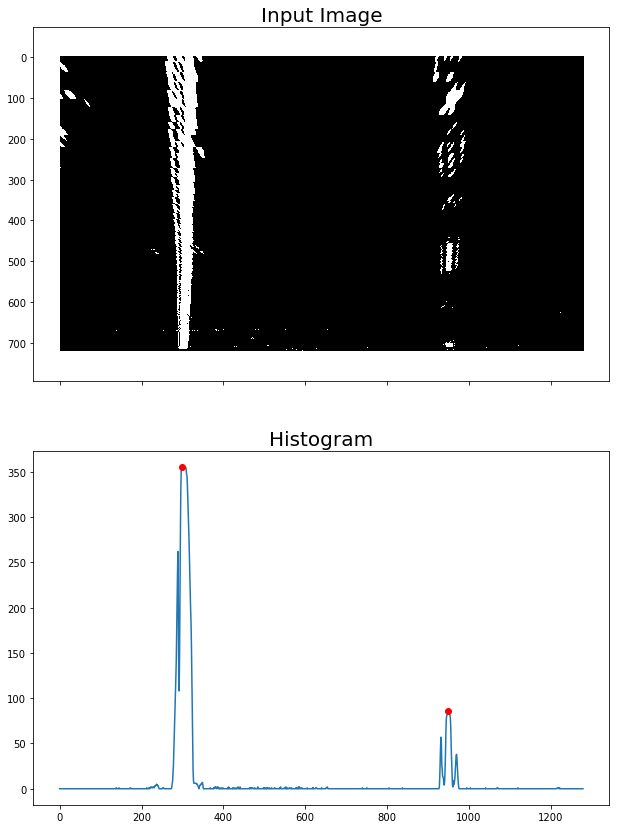

In [119]:
# get some measure
half_height = undist_road0_bin.shape[0]//2
midpoint = undist_road0_bin.shape[1]//2

# binary warped
binary_warped = cv2.warpPerspective(undist_road0_bin, P_M, IMG_CV_SHAPE, flags=cv2.INTER_LINEAR)

# taking the histogram of the half-bottom
histogram = np.sum(binary_warped[half_height:,:], axis=0)

# taking the peak
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
peaks = [leftx_base, rightx_base]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Input Image', fontsize=20)
ax2.plot(histogram)

ax2.plot(peaks, histogram[peaks], 'ro')
ax2.set_title('Histogram', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Using above starting point, we can use a sliding window placed around the line centers and follow the lines up to the top of the frame. Let's code it up in a function

In [120]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])  # y is heigh dimension => first dimension
nonzerox = np.array(nonzero[1])  # x is width dimension => second dimension

win_h = binary_warped.shape[0] // 9
win_y_low = binary_warped.shape[0] - win_h
win_y_high = binary_warped.shape[0]

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# define a windows
win_xleft_low = leftx_base - margin
win_xleft_high = leftx_base + margin
win_xright_low = rightx_base - margin
win_xright_high = rightx_base + margin

# find where nonzero points inside a window
nonzero_win_left = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

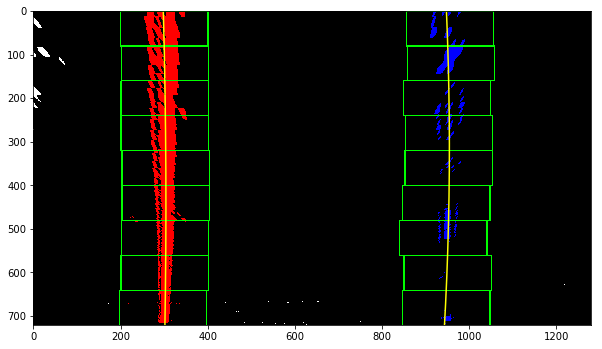

In [121]:
def find_line1(binary_warped, nwindows, margin = 100, minpix = 50):
    H, W = binary_warped.shape
    half_H = H // 2
    half_W = W // 2
    
    # histogram of the half-bottom
    half_bottom_hist = np.sum(binary_warped[half_height:,:], axis=0)
    
    # taking the peak as starting points
    leftx_base = np.argmax(half_bottom_hist[:half_W])
    rightx_base = np.argmax(half_bottom_hist[half_W:]) + half_W
    
    # height of sliding window
    window_H = H // nwindows
    
    # create empty lists to receive left and right lane pixel indices and sliding windows
    l_lane_idx = []
    r_lane_idx = []
    
    l_windows = []
    r_windows = []
    
    # set lane-line postion, then update for each window
    leftx_pos = leftx_base
    rightx_pos = rightx_base
    
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])  # y is heigh dimension => first dimension
    nonzerox = np.array(nonzero[1])  # x is width dimension => second dimension
    
    # slide through windows
    for iw in range(nwindows):
        # identify window boundaries
        win_y_low  = H - (iw+1) * window_H
        win_y_high = H - iw * window_H
        
        win_xleft_low = leftx_pos - margin
        win_xleft_high = leftx_pos + margin
        
        win_xright_low = rightx_pos - margin
        win_xright_high = rightx_pos + margin
        
        # store window-points
        l_windows.append([(win_xleft_low,  win_y_low), (win_xleft_high,  win_y_high)])
        r_windows.append([(win_xright_low, win_y_low), (win_xright_high, win_y_high)])
        
        # identify the nonzero pixels in x and y within the window (stored as index)
        nonzero_win_left = ((nonzeroy >= win_y_low)     & (nonzeroy < win_y_high) & \
                            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        nonzero_win_right = ((nonzeroy >= win_y_low)      & (nonzeroy < win_y_high) & \
                             (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # append these indices to the lists
        l_lane_idx.append(nonzero_win_left)
        r_lane_idx.append(nonzero_win_right)
        
        # re-adjust the position when you found enough pixels in a window
        if len(nonzero_win_left) > minpix:
            leftx_pos = np.int(np.mean(nonzerox[nonzero_win_left]))
        if len(nonzero_win_right) > minpix:
            rightx_pos = np.int(np.mean(nonzerox[nonzero_win_right]))
            
    # concatenate of indices
    l_lane_idx = np.concatenate(l_lane_idx)
    r_lane_idx = np.concatenate(r_lane_idx)
    
    # extract left and right lane pixel position
    leftx = nonzerox[l_lane_idx]
    lefty = nonzeroy[l_lane_idx] 
    rightx = nonzerox[r_lane_idx]
    righty = nonzeroy[r_lane_idx] 

    # finally fit a second order polynomial to each: note that we fit x = quadratic(y)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # return fitted curves, left-points, right-points and windows
    return (left_fit, right_fit), ((lefty, leftx), (righty, rightx)), (l_windows, r_windows)

def visualize_lane_line(binary_warped, 
                        left_right_fits, 
                        left_right_points,
                        left_right_windows):
    # create color image for the visualization
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # mark left point by red-color and right points by blue-color
    lefty, leftx   = left_right_points[0]
    righty, rightx = left_right_points[1]
    out_img[lefty,  leftx]  = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # draw windows
    left_windows, right_windows = left_right_windows
    nwindows = len(left_windows)
    for iw in range(nwindows):
        cv2.rectangle(out_img, left_windows[iw][0],  left_windows[iw][1],  (0,255,0), 2)
        cv2.rectangle(out_img, right_windows[iw][0], right_windows[iw][1], (0,255,0), 2)
    
    # draw the fitted curve
    left_fit, right_fit = left_right_fits
    ypoints = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_xpoints  = left_fit[0]*ypoints**2  + left_fit[1]*ypoints  + left_fit[2]
    right_xpoints = right_fit[0]*ypoints**2 + right_fit[1]*ypoints + right_fit[2]
    
    # plot it
    f, ax = plt.subplots(1, 1, figsize=(10, 12), sharex=True)
    ax.imshow(out_img)
    ax.plot(left_xpoints,  ypoints, color='yellow')
    ax.plot(right_xpoints, ypoints, color='yellow')
    ax.set_xlim(0, binary_warped.shape[1])
    ax.set_ylim(binary_warped.shape[0], 0)

left_right_fits_hist, left_right_points_hist, left_right_windows_hist = find_line1(binary_warped, 9)
visualize_lane_line(binary_warped, left_right_fits_hist, left_right_points_hist, left_right_windows_hist)

We can see the lane-line is reasonably well fitted. Now let's look at the second approach with convolution.

### Lane-line search with convolution
Another way to approach the sliding window histogram method is to apply a convolution, which will maximize the number of "hot" pixels in each window. A convolution is the summation of the product of two separate signals, in our case the window template and the vertical slice of the pixel image.

You slide your window template across the image from left to right and any overlapping values are summed together, creating the convolved signal. The peak of the convolved signal is where there was the highest overlap of pixels and the most likely position for the lane marker.

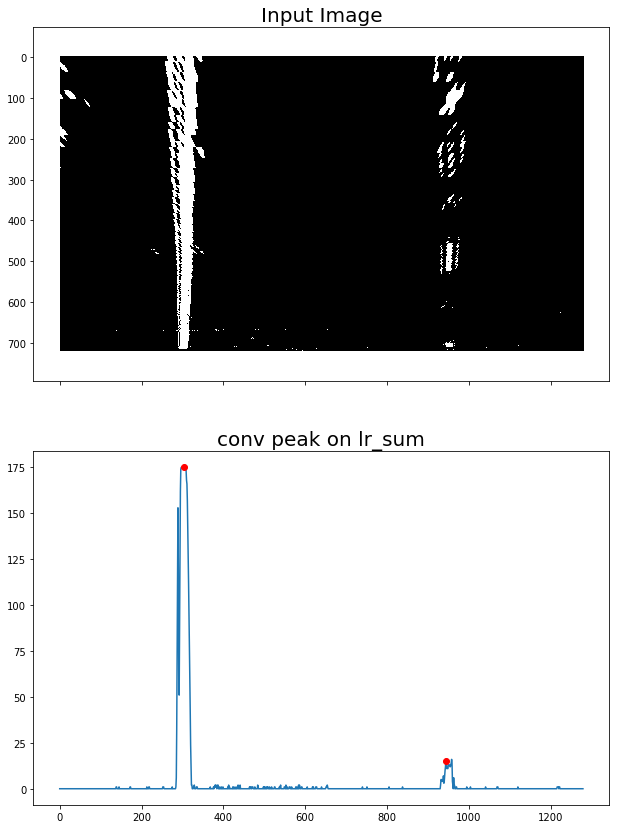

In [122]:
# create some variable
window_width = 50 
half_ww = window_width // 2
bottom_H = 3*H // 4
window = np.ones(window_width)

# sum quarter bottom of image to get slice, could use a different ratio
l_sum = np.sum(binary_warped[bottom_H:,:midpoint], axis=0)
l_center = np.argmax(np.convolve(window,l_sum)) - half_ww
r_sum = np.sum(binary_warped[bottom_H:,midpoint:], axis=0)
r_center = np.argmax(np.convolve(window,r_sum)) - half_ww + midpoint

peaks = [l_center, r_center]


# Draw left & right conv
f, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
ax1,ax2 = axes.flatten()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Input Image', fontsize=20)
lr_sum = np.concatenate([l_sum,  r_sum])
ax2.plot(lr_sum,  label='sum')
ax2.plot(peaks, lr_sum[peaks], 'ro')

ax2.set_title('conv peak on lr_sum', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The next step is similar as before where we slide through the image, on each sliding window we take the convolution and recompute the peak. Let's implement it

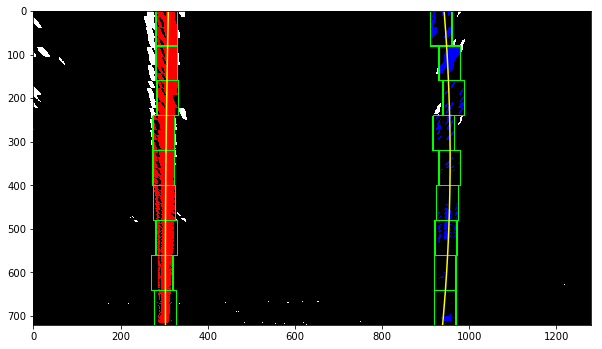

In [123]:
def find_ceintroids(binary_warped, nwindows, window_width=50, margin=100):
    H,W = binary_warped.shape
    window_height = H // nwindows
    
    window_centroids = []
    window = np.ones(window_width)
    
    # get starting points: using 1/4 bottom part
    bottom_H = 3*H // 4
    half_ww = window_width // 2
    
    l_sum = np.sum(binary_warped[bottom_H:,:midpoint], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum)) - half_ww
    r_sum = np.sum(binary_warped[bottom_H:,midpoint:], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum)) - half_ww + midpoint
    
    window_centroids.append((l_center,r_center))
    
    for iw in range(1, nwindows):
        # get image layer
        win_y_low  = H - (iw+1) * window_height
        win_y_high = H - iw * window_height
        image_layer = np.sum(binary_warped[win_y_low:win_y_high,:], axis=0)
        
        # compute convolution
        conv_signal = np.convolve(window, image_layer)
        
        # find the best left/right centroid by using past left/right as a reference
        # we assume new centroid has difference to the past one less than margin        
        l_min_idx = max(l_center + half_ww - margin, 0) 
        l_max_idx = min(l_center + half_ww + margin, W)
        
        r_min_idx = max(r_center + half_ww - margin, 0)
        r_max_idx = min(r_center + half_ww + margin, W)
        
        # update centroid
        l_center = np.argmax(conv_signal[l_min_idx:l_max_idx]) + l_min_idx - half_ww
        r_center = np.argmax(conv_signal[r_min_idx:r_max_idx]) + r_min_idx - half_ww
        
        # append new centroid
        window_centroids.append((l_center,r_center))
    return window_centroids

def find_line2(binary_warped, nwindows, window_width=50, margin=100):    
    # get centroids
    window_centroids = find_ceintroids(binary_warped, nwindows, window_width=window_width, margin=margin)
    
    window_height = H // nwindows
    half_ww = window_width // 2
    
    # create empty lists to receive left and right lane pixel indices and sliding windows
    l_lane_idx = []
    r_lane_idx = []
    
    l_windows = []
    r_windows = []
    
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])  # y is heigh dimension => first dimension
    nonzerox = np.array(nonzero[1])  # x is width dimension => second dimension
    
    for iw in range(nwindows):
        l_center, r_center = window_centroids[iw]
        
        win_y_low  = H - (iw+1) * window_height
        win_y_high = H - iw * window_height
        
        win_xleft_low  = l_center - half_ww
        win_xleft_high = l_center + half_ww
        
        win_xright_low  = r_center - half_ww
        win_xright_high = r_center + half_ww
        
        # store window-points
        l_windows.append([(win_xleft_low,  win_y_low), (win_xleft_high,  win_y_high)])
        r_windows.append([(win_xright_low, win_y_low), (win_xright_high, win_y_high)])
        
        # identify the nonzero pixels in x and y within the window (stored as index)
        nonzero_win_left = ((nonzeroy >= win_y_low)     & (nonzeroy < win_y_high) & \
                            (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        
        nonzero_win_right = ((nonzeroy >= win_y_low)      & (nonzeroy < win_y_high) & \
                             (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # append these indices to the lists
        l_lane_idx.append(nonzero_win_left)
        r_lane_idx.append(nonzero_win_right)
    
    # concatenate of indices
    l_lane_idx = np.concatenate(l_lane_idx)
    r_lane_idx = np.concatenate(r_lane_idx)
    
    # extract left and right lane pixel position
    leftx = nonzerox[l_lane_idx]
    lefty = nonzeroy[l_lane_idx] 
    rightx = nonzerox[r_lane_idx]
    righty = nonzeroy[r_lane_idx] 

    # finally fit a second order polynomial to each: note that we fit x = quadratic(y)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # return fitted curves, left-points, right-points and windows
    return (left_fit, right_fit), ((lefty, leftx), (righty, rightx)), (l_windows, r_windows)

left_right_fits, left_right_points, left_right_windows = find_line2(binary_warped, 9)
visualize_lane_line(binary_warped, left_right_fits, left_right_points, left_right_windows)

We obtain similar result as previous method.

Next step is to draw lane line onto origial image

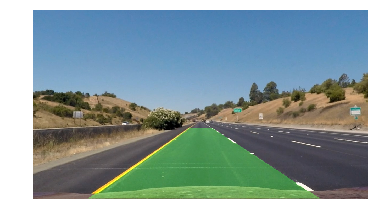

In [124]:
def draw_lane_area(in_img, binary_warped, left_right_fits):
    # left/right lane-lines
    left_fit, right_fit = left_right_fits
    ypoints = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_xpoints  = left_fit[0]*ypoints**2  + left_fit[1]*ypoints  + left_fit[2]
    right_xpoints = right_fit[0]*ypoints**2 + right_fit[1]*ypoints + right_fit[2]
    
    # create an image to draw the lane-line area on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_xpoints, ypoints]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_xpoints, ypoints])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, P_Minv, IMG_CV_SHAPE) 
    
    # Combine the result with the original image
    return cv2.addWeighted(in_img, 1, newwarp, 0.3, 0)

lane_line_road0 = draw_lane_area(undist_road0, binary_warped, left_right_fits_hist)
show_img(lane_line_road0, None)

## Measuring curvature and car position

### Measuring curvature
From this [tutorial](http://www.intmath.com/applications-differentiation/8-radius-curvature.php), at any point $x$ of function $x=f(y)$, the radius of curvature is given as follows
$$
R_{curve} = \frac{\left[1+f'(y)^2\right]^{3/2}}{|f''(y)|}
$$
In the case of the second order polynomial above, the first and second derivatives are
$$
\begin{split}
f'(y)  &= 2Ay + B\\
f''(y) &= 2A
\end{split}
$$
So our equation for radius of curvature becomes
$$
R_{curve} = \frac{\left[1+\left(2Ay+B\right)^2\right]^{3/2}}{|2A|}
$$

Note that we need to measure radius in meters, however we have image in pixel, so the first step is to convert pixel into meters then refit the curves. We use the following constant to convert pixel to meter
$$
\begin{split}
\texttt{ym_per_pixel} &= 30/720\\
\texttt{xm_per_pixel} &= 3.7/700
\end{split}
$$

In [125]:
def measure_curvature(ypoints, left_xpoints, right_xpoints, ypix2m = 30./720, xpix2m=3.7/700, quad_eps = 1e-4):
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ypoints) * ypix2m
    ypoints_m   = ypoints * ypix2m
    
    left_fit_cr = np.polyfit(ypoints_m,  left_xpoints * xpix2m, 2)
    right_fit_cr = np.polyfit(ypoints_m, right_xpoints * xpix2m, 2)
    
    # compute curvature radius
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5)    / (2*max(quad_eps,np.abs(left_fit_cr[0])))
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / (2*max(quad_eps,np.abs(right_fit_cr[0])))
    
    return left_curverad, right_curverad

left_fit, right_fit = left_right_fits_hist
ypoints = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_xpoints  = left_fit[0]*ypoints**2  + left_fit[1]*ypoints  + left_fit[2]
right_xpoints = right_fit[0]*ypoints**2 + right_fit[1]*ypoints + right_fit[2]

print('Curvature radius (m): {}'.format(measure_curvature(ypoints, left_xpoints, right_xpoints)))

Curvature radius (m): (5000.0336428116443, 2410.9624499787683)


### Measuring car position
We can assume that the camera is mounted at the center of the car, such that the lane center is the midpoint at the bottom of the image between the two lines you've dectedted. The offset of the lane center from the center of the image (converted from pixels to meters) is your distance from the center of the lane.

In [130]:
def measure_offset(ypoints, left_xpoints, right_xpoints, xpix2m = 3.7/700):
    i = np.argmax(ypoints)
    yval = ypoints[i]
        
    xcenter = (left_xpoints[i] + right_xpoints[i]) / 2
    print(yval, xcenter)
    pts = np.array([[[xcenter, yval]]], dtype = np.float64)
    orig_pts = cv2.perspectiveTransform(pts, P_Minv)
    offset_pixel = orig_pts[0][0][0] - midpoint
    return offset_pixel * xpix2m

print('Offset from center-lane (m): {:.3f}'.format(measure_offset(ypoints, left_xpoints, right_xpoints)))
print(left_fit)
print(right_fit)

719.0 622.566769734
Offset from center-lane (m): 0.074
[ -3.03698051e-05   2.69762447e-02   2.98188034e+02]
[ -6.81216553e-05   4.28805066e-02   9.47634745e+02]
